In [17]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import average_precision_score, precision_recall_curve, precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler, normalize
from sklearn.metrics import classification_report,confusion_matrix

In [18]:
### READING DATASET ###

# Paths
dataset_path = 'Dataset'
games_dir = next(os.walk(dataset_path))[1]

tag_to_skip = ['highlights', 'highlights2', '.DS_Store', '.git']

# Iterating through games
games_data = []
games_path = [os.path.join(dataset_path, g) for g in games_dir]
for path in games_path:
    game_name = os.path.basename(path)
    if game_name != 'ned_svk':
        game_info = os.listdir(path)
        data = dict()
        for info in game_info:
            tag_name = os.path.splitext(info)[0]
            if tag_name not in tag_to_skip:
                csv_file = os.path.join(path, info)
                if tag_name == 'highlights_boundaries':
                    data_value = np.genfromtxt(csv_file, delimiter=',', dtype=None)
                else:
                    data_value = np.fromfile(csv_file, dtype=np.float64)
                data[tag_name] = data_value
            data['name'] = game_name
        games_data.append(data)

games_backup = games_data[:]

In [19]:
### REMOVENDO VALORES CORRELACIONADOS ###

to_remove = ['em_mcs_energy', 'em_mcs_energy_diff', 'em_mcs_energy_diff_ascending']
for game in games_data:
    for tag in to_remove:
        del game[tag]

In [20]:
### CRIANDO VETOR DE GT ###

normal_cases = ['Normal', 'Inicio', 'Fim']
to_skip = ['name', 'highlights_boundaries']

for game in games_data:
    h = game['highlights_boundaries']
    end = h[-1][0]
    gt = np.zeros(end)
    slices = []
    for line in h:
        tag = line[2].decode('UTF-8').split(' ')
        name = [t for t in tag if t != ''][0]
        if name not in normal_cases:
            gt[line[0]-1:line[1]] = 1
        else:
            slices.append([line[0], line[1], name])

    slices = slices[::-1]
    ## Removing data not to be considered ###
    for k, values in game.items():
        if k not in to_skip:
            for sl in slices:
                if 'Fim' in sl[2]:
                    values = np.delete(values, range(sl[0], len(values)))
                if 'Normal' in sl[2]:
                    values = np.delete(values, range(sl[0], sl[1]))
                if 'Inicio' in sl[2]:
                    values = np.delete(values, range(0, sl[0]))
        game[k] = values
                    
            
    game['gt'] = gt
    del game['highlights_boundaries']

/Users/admin/py3env/lib/python3.5/site-packages/ipykernel/__main__.py:27: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


In [21]:
### CORTANDO VALORES EXCEDENTES PARA QUE TODOS OS DADOS TENHAM O MESMO TAMANHO ###

for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    min_l = min(values)
    for k, v in game.items():
        if len(v) > min_l:
            game[k] = v[:min_l]
            

### ZERO PADDING ###
max_length = 0
for game in games_data:
    values = [len(v) for k, v in game.items() if k not in ['name']]
    max_length = max(values) if max(values)>max_length else max_length

for game in games_data:
    for k, v in game.items():
        if k not in ['name']:
            zero_v = np.zeros(max_length)
            if len(v) < max_length:
                zero_v[:len(v)] = v
                game[k] = zero_v

In [22]:
### DIVIDING SPLITS FROM TRAIN, EVAL, TEST ###

games_name = [g['name'] for g in games_data]
games_train1, games_test = train_test_split(games_name, test_size=0.15)
games_train2, games_val = train_test_split(games_train1, test_size=0.05)

print('Total train: {}'.format(len(games_train2)))
print('Total test: {}'.format(len(games_test)))
print('Total val: {}'.format(len(games_val)))

Total train: 22
Total test: 5
Total val: 2


In [23]:
for i, tag_name in enumerate(games_data[10].keys()):
    print('{} - {}'.format(i, tag_name))
    if tag_name == 'name':
        name_id = i
    if tag_name == 'gt':
        gt_id = i
        
print('\nnome_id: {}, gt_id: {}'.format(name_id, gt_id))

0 - pm_pitch
1 - em_st_energy_diff_ascending
2 - gt
3 - em_cs_energy_diff_ascending
4 - pc_delta
5 - dc_percent
6 - em_cs_energy
7 - em_st_energy
8 - pc_var_theta
9 - pc_rho
10 - dc_hue_mean
11 - em_st_energy_diff
12 - pm_pitch_diff
13 - pc_var_delta
14 - name
15 - pm_pitch_diff_ascending
16 - em_cs_energy_diff
17 - pc_theta

nome_id: 14, gt_id: 2


In [24]:
X_train = []
y_train = []

for game in games_data:
    if game['name'] in games_train1:
        values_array = list(game.values())
        # Getting GT
        y_train += list(values_array[gt_id])
        
        # Removing name and GT to train
        del values_array[max(name_id, gt_id)]
        del values_array[min(name_id, gt_id)]
        
        values_array = np.array(values_array)
        if len(X_train) == 0:
            X_train = np.transpose(values_array)
        else:
            X_train = np.concatenate((X_train, np.transpose(values_array)))
y_train = np.array(y_train)    


X_test = []
y_test = []

for game in games_data:
    if game['name'] in games_test:
        values_array = list(game.values())
        # Getting GT
        y_test += list(values_array[gt_id])
        
        # Removing name and GT to train
        del values_array[max(name_id, gt_id)]
        del values_array[min(name_id, gt_id)]
        
        values_array = np.array(values_array)
        if len(X_test) == 0:
            X_test = np.transpose(values_array)
        else:
            X_test = np.concatenate((X_test, np.transpose(values_array)))
y_test = np.array(y_test)
            
normalize(X_train, axis=1, copy=False)
normalize(X_test, axis=1, copy=False)
    
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (2000880, 16) (2000880,)
Test (416850, 16) (416850,)



 * Training: constant learning-rate
Training set score: 0.988776
Training set loss: 0.060764
Testing set score: 0.986367
[[411167      0]
 [  5683      0]]


/Users/admin/py3env/lib/python3.5/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99    411167
        1.0       0.00      0.00      0.00      5683

avg / total       0.97      0.99      0.98    416850


 * Training: constant with momentum
Training set score: 0.988776
Training set loss: 0.060517
Testing set score: 0.986367
[[411167      0]
 [  5683      0]]
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99    411167
        1.0       0.00      0.00      0.00      5683

avg / total       0.97      0.99      0.98    416850


 * Training: constant with Nesterov's momentum
Training set score: 0.988776
Training set loss: 0.060520
Testing set score: 0.986367
[[411167      0]
 [  5683      0]]
             precision    recall  f1-score   support

        0.0       0.99      1.00      0.99    411167
        1.0       0.00      0.00      0.00      5683

avg / total       0.97      0.99      0.98    416850


 * Training: inv-scaling lear

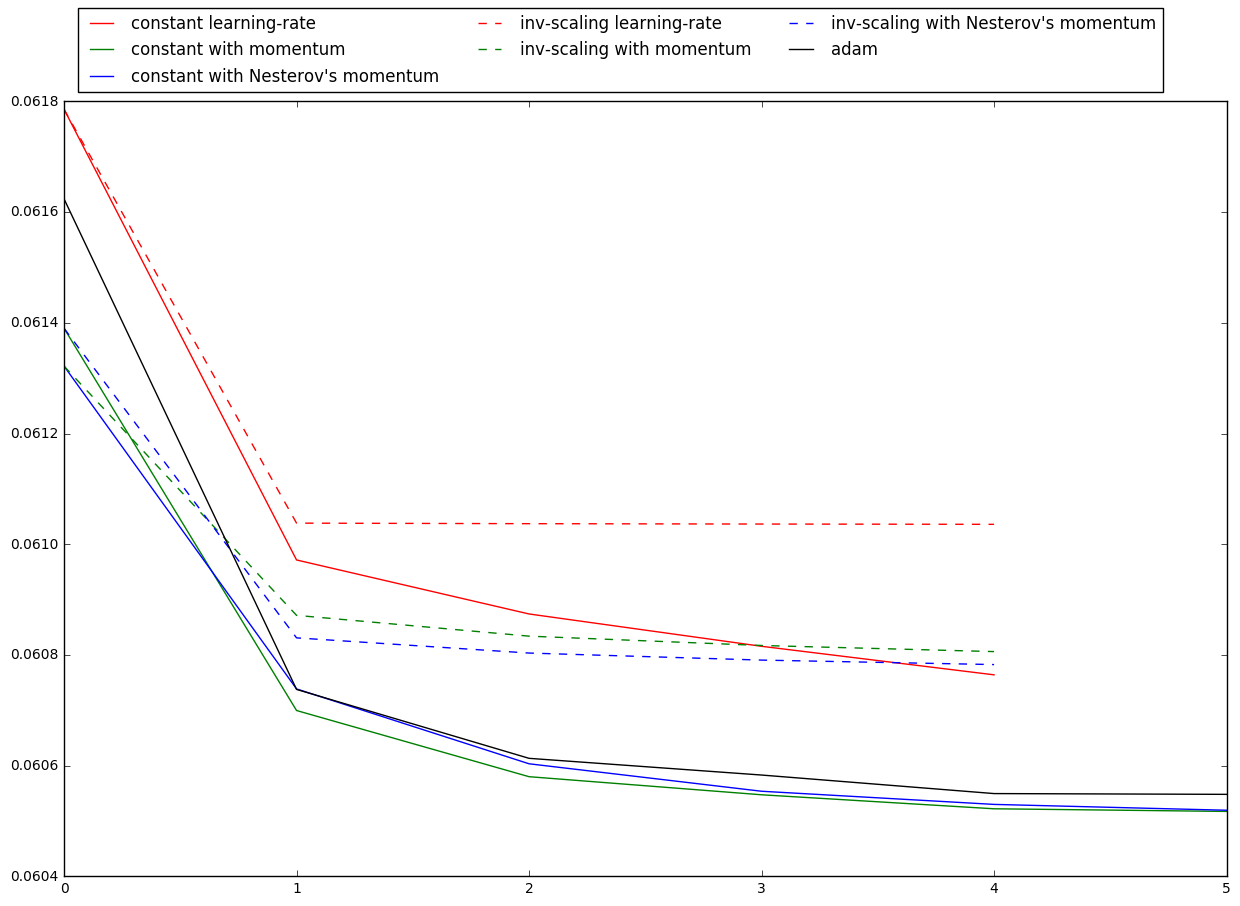

In [27]:
# different learning rate schedules and momentum parameters
params = [{'solver': 'sgd', 'learning_rate': 'constant', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'constant', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': 0,
           'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': True, 'learning_rate_init': 0.2},
          {'solver': 'sgd', 'learning_rate': 'invscaling', 'momentum': .9,
           'nesterovs_momentum': False, 'learning_rate_init': 0.2},
          {'solver': 'adam', 'learning_rate_init': 0.01}]

labels = ["constant learning-rate", "constant with momentum",
          "constant with Nesterov's momentum",
          "inv-scaling learning-rate", "inv-scaling with momentum",
          "inv-scaling with Nesterov's momentum", "adam"]

plot_args = [{'c': 'red', 'linestyle': '-'},
             {'c': 'green', 'linestyle': '-'},
             {'c': 'blue', 'linestyle': '-'},
             {'c': 'red', 'linestyle': '--'},
             {'c': 'green', 'linestyle': '--'},
             {'c': 'blue', 'linestyle': '--'},
             {'c': 'black', 'linestyle': '-'}]


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
X = MinMaxScaler().fit_transform(X_train)
X_eval = MinMaxScaler().fit_transform(X_test)
mlps = []
max_iter = 400

for label, param in zip(labels, params):
    print("\n * Training: %s" % label)
    mlp = MLPClassifier(verbose=0, random_state=0,
                        max_iter=max_iter, **param)
    mlp.fit(X, y_train)
    mlps.append(mlp)
    predictions = mlp.predict(X_test)
    print("Training set score: %f" % mlp.score(X, y_train))
    print("Training set loss: %f" % mlp.loss_)
    print("Testing set score: %f" % mlp.score(X_eval, y_test))
    print(confusion_matrix(y_test,predictions))
    print(classification_report(y_test,predictions))
for mlp, label, args in zip(mlps, labels, plot_args):
    ax.plot(mlp.loss_curve_, label=label, **args)


fig.legend(ax.get_lines(), labels, ncol=3, loc="upper center")
plt.show()

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# Fit only to the training data
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

print(scaler.mean_)
print(len(scaler.mean_))

[  1.66906484e-034   2.71541865e-260   2.71541865e-260   8.45516369e-036
   1.98261223e-034   2.17862457e-034   2.25319327e-034   1.07246132e-034
   2.71705191e-260   1.97371904e-034   2.17071277e-034   1.80322438e-034
   7.41010113e-035   2.71541865e-260   2.29506799e-034   4.37819998e-035]
16


In [10]:
mlp = MLPClassifier(hidden_layer_sizes=(13,13,13),max_iter=500)
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(13, 13, 13), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [11]:
predictions = mlp.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))

In [ ]:
from imblearn.under_sampling import TomekLinks

# remove Tomek links
tl = TomekLinks(return_indices=True)
X_resampled, y_resampled, idx_resampled = tl.fit_sample(X_all[:,:1], y_all)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

idx_samples_removed = np.setdiff1d(np.arange(X_all.shape[0]), idx_resampled)
idx_class_0 = y_resampled == 0
plt.scatter(X_resampled[idx_class_0, 0], X_resampled[idx_class_0, 1], alpha=.8, label='Class #0')
plt.scatter(X_resampled[~idx_class_0, 0], X_resampled[~idx_class_0, 1], alpha=.8, label='Class #1')
plt.scatter(X_syn[idx_samples_removed, 0], X_all[idx_samples_removed, 1], alpha=.8, label='Removed samples')
plt.title('Undersampling: Tomek links')
plt.legend()
plt.show()